In [1]:
# File: main.ipynb
import os
import random
import sys
import numpy as np
import PIL
import torch
import torchvision
import json
import gc
import argparse
from matplotlib import pyplot as plt

from trainer import Trainer
from models.vanilla import VanillaModel
import models.model as model_file
from run_args import RunArgs
from utils.myUtils import (
    CompositeLoss,
    MS_SSIMLoss,
    MSELoss,
    PSNRLoss,
    psnr,
    visualize_reconstructions,
    get_next_experiment_number,
    get_main_py_dir_abs_path,
    calc_psnrs,
    save_psnrs_results,
    clear_memory,
    plot_list,
    scale_learning_rate,
    print_groups_lr,
    get_first_group_lr,
)
from utils.utils import create_data_loaders, freq_to_image

assert torch.cuda.is_available()

is_run_in_notebook = False


def is_notebook():
    try:
        from IPython import get_ipython

        if "IPKernelApp" not in get_ipython().config:  # Kernel not running
            return False
    except (ImportError, AttributeError):
        return False
    return True


# Usage example:
if is_notebook():
    # import the relevant tqdm module
    print("This is running in a notebook.")
    is_run_in_notebook = True
    # from tqdm.notebook import tqdm
    from tqdm import tqdm  # Let's use it anyway, its better
else:
    print("This is not running in a notebook.")
    from tqdm import tqdm

main_py_dir_abs_path = get_main_py_dir_abs_path()
print(f"main_py_dir_abs_path: {main_py_dir_abs_path}")
exp_num = get_next_experiment_number(
    os.path.join(main_py_dir_abs_path, "exp_number.txt")
)
print(f"Experiment number: {exp_num}")

/home/priel.hazan/miniconda3/envs/deepP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is running in a notebook.
main_py_dir_abs_path: /home/priel.hazan/DeepProj/DL-MRI-CompressedSensing
Experiment number: 183


In [2]:
def run_with_args(args):
    print(f"Running with args:\n{args}")

    def get_new_reconstruction_model(args):
        # for 0.3 drop rate:
        # Gets 0.094 MSE loss after 1 epoch.
        # encoder_decoder = model_file.UNET(in_channels=1, out_channels=1)

        # encoder_decoder = model_file.UNetV1(in_channels=1, n_classes=1) # poor results

        # Gets ~0.065 MSE loss after 1 epoch, amazing! and 0.048 at its best.
        encoder_decoder = model_file.UNet_2Plus(in_channels=1, n_classes=1)

        # Not good performance:
        # encoder_decoder = model_file.UNet_3Plus(in_channels=1, n_classes=1)

        # gets little bit worse results that UNET:
        # encoder_decoder = model_file.UNetV2(
        #     n_classes=1, deep_supervision=False, pretrained_path=None, channel=32
        # )

        return model_file.ReconstructionModel(
            args.drop_rate, args.device, args.learn_mask, encoder_decoder
        ).to(args.device)

    model = get_new_reconstruction_model(args)

    experiment_dir = os.path.join(
        args.results_root,
        f"exp{exp_num}_drop{args.drop_rate}_mask_lr{args.mask_lr}_model_{model.get_name()}",
    )
    print(f"results_root: {args.results_root}")
    print(f"Experiment directory: {experiment_dir}")
    figures_dir = os.path.join(experiment_dir, "figures")
    print(f"Figures directory: {figures_dir}")
    os.makedirs(figures_dir, exist_ok=True)

    # freeze seeds for result reproducability
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    print("Seed: ", args.seed)  # Piazza said we must not change seed!

    # Try different Losses.
    mse_loss = MSELoss()
    criterion = mse_loss
    # MAE:
    # mae_loss = torch.nn.L1Loss()
    # Attention - must change max_val and data_range cause now around [-2, 8]
    # criterion = PSNRLoss(max_val=1.0, epsilon=1e-8)
    # 4 for the plus, and 8 for the rest.

    # Using only ms ssim proven less than with MSE, but using only MSE gives the best results.
    # ms_data_range = 50.0
    # add_mse = True
    # # add_mse = False
    # ms_ssim_loss = MS_SSIMLoss(
    #     args.device, add_mse, data_range=ms_data_range, reduction="mean"
    # )
    # criterion = ms_ssim_loss
    # create nn.module that sums losses

    # class AddedLosses(torch.nn.Module):
    #     def __init__(self, losses_list):
    #         super(AddedLosses, self).__init__()
    #         self.losses_list = losses_list

    #     def forward(self, x, y):
    #         return sum([loss(x, y) for loss in self.losses_list])

    # losses_list = [mse_loss, ms_ssim_loss]
    # criterion = AddedLosses(losses_list)

    # * loss = MAE + MSE together - show less performance than MSE alone.
    # losses_list = [mse_loss, mae_loss]
    # criterion = AddedLosses(losses_list)
    # criterion = ms_ssim_loss

    # criterion = CompositeLoss(
    #     args.device,
    #     mse_weight=1.0,
    #     ms_ssim_weight=1.0,
    #     mae_weight=1.0,
    #     data_range=ms_data_range,
    # )

    # * Adam proven empirically to be much better than SGD
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)

    dir_to_save_images_abs_path = os.path.join(
        experiment_dir,
        "reconstructions_examples",
    )
    if not os.path.exists(dir_to_save_images_abs_path):
        os.makedirs(dir_to_save_images_abs_path)
    else:
        print(f"Directory {dir_to_save_images_abs_path} already exists.")

    dir_to_save_images_abs_path = os.path.abspath(dir_to_save_images_abs_path)
    print(f"Saving images(if not ipynb) to: {dir_to_save_images_abs_path}")

    # Optional - stop epoch after several batches for debugging:
    stop_epoch_after_num_batches = None
    # stop_epoch_after_num_batches = 20

    trainer = Trainer(
        model,
        criterion,
        optimizer,
        args,
        stop_epoch_after_num_batches,
        exp_num,
        experiment_dir,
        figures_dir,
        is_run_in_notebook,
        dir_to_save_images_abs_path,
    )
    trainer.fit()

Using drop_rate=0.3, learn_mask=False
Running with args:
Results root: /mnt/cslash2/priel/deepProject/results/
Seed: 0
Data path: /mnt/cslash2/priel/fastmri_knee/
Device: cuda
Batch size: 16
Num workers: 1
Num epochs: 20
Report interval: 80
Drop rate: 0.3
Learn mask: False
Lr: 0.0001
Mask lr: NA
Val test split: 0.3
Early stopping: 1
Scale: 0.3
Scale mask lr: NA
Start from cp: /mnt/cslash2/priel/deepProject/results/exp168_drop0.3_mask_lrNA_model_UNet_2Plus/epoch_3/cp_epoch_3.pt


results_root: /mnt/cslash2/priel/deepProject/results/
Experiment directory: /mnt/cslash2/priel/deepProject/results/exp183_drop0.3_mask_lrNA_model_UNet_2Plus
Figures directory: /mnt/cslash2/priel/deepProject/results/exp183_drop0.3_mask_lrNA_model_UNet_2Plus/figures
Seed:  0
Saving images(if not ipynb) to: /mnt/cslash2/priel/deepProject/results/exp183_drop0.3_mask_lrNA_model_UNet_2Plus/reconstructions_examples
Loading checkpoint from:  /mnt/cslash2/priel/deepProject/results/exp168_drop0.3_mask_lrNA_model_UNet_2Plus/epoch_3/cp_epoch_3.pt
Loaded checkpoint. Starting epoch: 4, best_val_mean_loss: 0.005426016572403581
In fit method, starting epoch_idx: 4
Total memory on cuda: 50.82 GB
before cleanup: Memory on cuda: 0.76 GB used, 50.06 GB free, 
after cleanup(freed 0.00 GB): Memory on cuda: 0.76 GB used, 50.06 GB free, 
Progress:   0%|          | 0/869 [00:00<?, ?it/s]Training with lr_in_epoch: 8.1e-07, mask_lr_in_epoch: NA
ms_ssim: 0.29435


 --------------------- Saving images epoch 4, tra

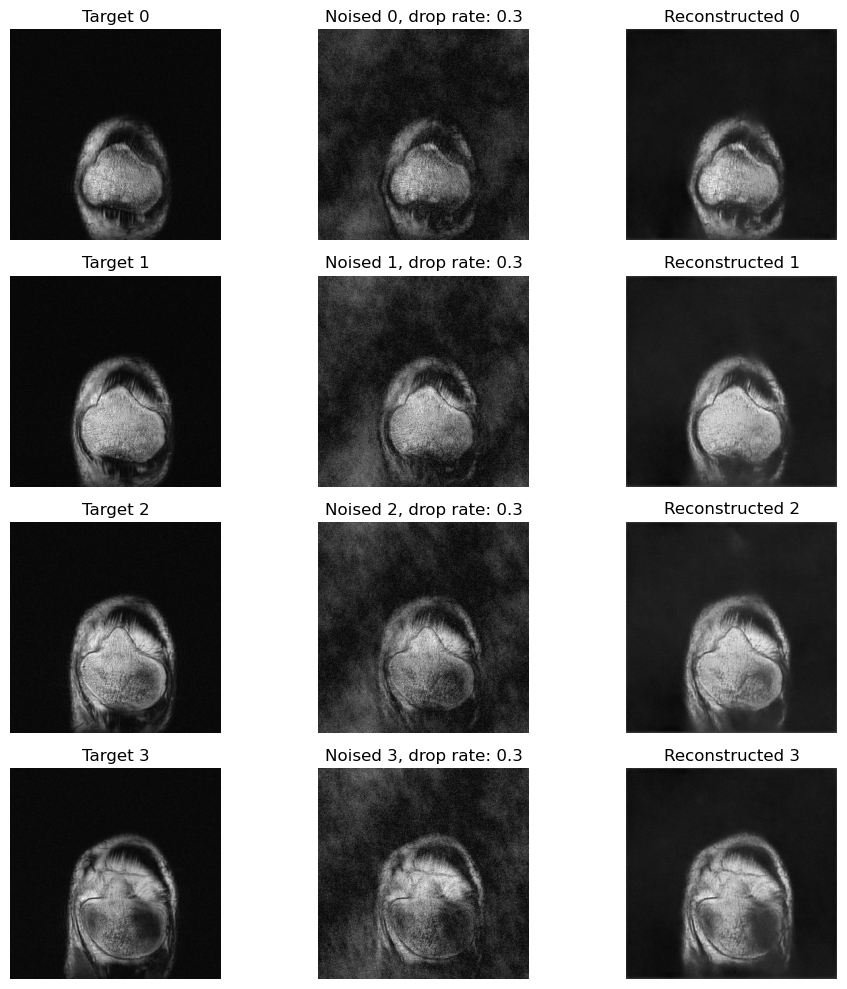

Train Epoch: 4, Loss: 0.2943, Batch: 0, Lr: 8.1e-07, mask_lr: NA:   0%|          | 1/869 [00:09<2:21:43,  9.80s/it]ms_ssim: 0.06761
Train Epoch: 4, Loss: 0.0676, Batch: 1, Lr: 8.1e-07, mask_lr: NA:   0%|          | 3/869 [00:10<41:55,  2.91s/it]  ms_ssim: 0.07653
Train Epoch: 4, Loss: 0.0765, Batch: 2, Lr: 8.1e-07, mask_lr: NA:   1%|          | 5/869 [00:11<23:55,  1.66s/it]ms_ssim: 0.06797
Train Epoch: 4, Loss: 0.0680, Batch: 3, Lr: 8.1e-07, mask_lr: NA:   1%|          | 6/869 [00:13<25:50,  1.80s/it]ms_ssim: 0.08962
Train Epoch: 4, Loss: 0.0896, Batch: 4, Lr: 8.1e-07, mask_lr: NA:   1%|          | 8/869 [00:16<23:58,  1.67s/it]ms_ssim: 0.08377
Train Epoch: 4, Loss: 0.0838, Batch: 5, Lr: 8.1e-07, mask_lr: NA:   1%|          | 9/869 [00:19<28:15,  1.97s/it]ms_ssim: 0.07762
Train Epoch: 4, Loss: 0.0776, Batch: 6, Lr: 8.1e-07, mask_lr: NA:   1%|          | 10/869 [00:22<31:02,  2.17s/it]

In [3]:
def get_cmd_args():
    parser = argparse.ArgumentParser(
        description="Process the drop rate and learning mask."
    )
    parser.add_argument(
        "--drop_rate",
        type=float,
        required=False,
        help="Drop rate (float between 0.0 and 1.0).",
    )
    parser.add_argument(
        "--learn_mask",
        action="store_true",
        default=False,
        help="Flag to learn mask (set this flag to enable).",
    )

    return parser.parse_args()


# Usage example: --learn_mask for store True, else it's False
# python main.py --drop_rate 0.3 --learn_mask
# python main.py --drop_rate 0.3

# and with sbatch:
# sbatch run_job.sh --drop_rate 0.5
# sbatch run_job.sh --drop_rate 0.5 --learn_mask


def main():
    use_cmd_args = False
    if not is_run_in_notebook:
        cmd_args = get_cmd_args()
        if cmd_args.drop_rate is None:
            print("Drop rate not specified so not using cmd_args.")
        else:
            use_cmd_args = True
            print(f"cmd_args got: {cmd_args.drop_rate=}, {cmd_args.learn_mask=}")

    # * Attention - data dir copied to newton cluster, so change RunArgs accordingly.
    # they said we can use any hardware we want in piazza.

    # Our default values if cmd line not specified:
    drop_rate = 0.3
    learn_mask = False
    if use_cmd_args:
        drop_rate = cmd_args.drop_rate
        learn_mask = cmd_args.learn_mask
    print(f"Using drop_rate={drop_rate}, learn_mask={learn_mask}")
    args_to_run_with = None
    args_to_run_with = RunArgs(
        num_workers=1,
        # num_workers=0,  # will work, but extremely slow
        num_epochs=20,  # think its enough, cause early stop used.
        # batch_size=32, # not proven as better...
        batch_size=16,
        drop_rate=drop_rate,
        learn_mask=learn_mask,
        scale=0.3,  # multiply lr by this factor every epoch
        # lr=0.001,  # 0.11 MSELoss in 1 epoch
        lr=0.0001,  # 0.094 MSELoss in 1 epoch. Our best starting point.
        # will mul mask_lr every epoch, cause want constant noised images distribution
        scale_mask_lr=0.2,
        # mask_lr=0.01,  # their default
        # mask_lr=1.0, # pretty noisy train graph, got to 0.1 MSE loss after epoch
        # think it's good, cause scale_mask_lr=0.2 will reduce it.
        mask_lr=0.1,
        early_stopping=1,  # stop after 1 epochs without improvement.
        report_interval=80,
        # * If we get preemption from the server - choose the last checkpoint saved for the experiment and continue training from there.
        # start_from_cp="/home/priel/Downloads/deepProj/DL-MRI-CompressedSensing/results/exp125_drop0.3_mask_lrNA_model_UNET/epoch_0/cp_epoch_0.pt",
        # 168 with ms ssim only:
        # start_from_cp="/mnt/cslash2/priel/deepProject/results/exp168_drop0.3_mask_lrNA_model_UNet_2Plus/epoch_3/cp_epoch_3.pt",
        # 170 with ms ssim + mse:
        # start_from_cp="/mnt/cslash2/priel/deepProject/results/exp170_drop0.3_mask_lrNA_model_UNet_2Plus/epoch_3/cp_epoch_3.pt",
        # exp199_drop0.1_mask_lr0.1_model_UNet_2Plus:
        # start_from_cp="/mnt/cslash2/priel/deepProject/results/exp199_drop0.1_mask_lr0.1_model_UNet_2Plus/epoch_2/cp_epoch_2.pt",
        # exp200_drop0.1_mask_lrNA_model_UNet_2Plus:
        # start_from_cp="/mnt/cslash2/priel/deepProject/results/exp200_drop0.1_mask_lrNA_model_UNet_2Plus/epoch_2/cp_epoch_2.pt",
    )
    if not args_to_run_with.learn_mask:
        args_to_run_with.mask_lr = "NA"
        args_to_run_with.scale_mask_lr = "NA"
    run_with_args(args_to_run_with)


if __name__ == "__main__":
    main()